<a href="https://colab.research.google.com/github/likaelvan/Rain-Watcher/blob/main/Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS 180 Project: Rainfall Time Series
This project is developed by:
- W. N. Coronel (THU) \\
- J. E. Sarenas (THW) \\
- G. N. Vedasto (THV) \\
- Z. I. Pacaldo (THV) \\

### Project Summary

*   Importing Libraries
*   Mounting Google Drive
*   Data Preprocessing
  *   Reading data inti pandas data frame
  *   Set the date as index
  *   Remove Missing Values
  *   Plotting the data
* Linear Regression
  *   Adding time step feature
  *   Plot time regression
  *   Adding Lag Feature
  *   Modelling
  * Evaluating Regression Model with NRMSE
* SARIMAX
  *   Prepare dataset
  *   Identify best SARIMAX parameters
  *   Modelling
  * Evaluating SARIMAX Model with NRMSE
* Formulate Rain forecast








#### Importing Libraries

In [ ]:
pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# For data visualisation and manipulation
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Matplotlib defaults
%matplotlib inline 
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(15, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
    figsize=(12, 5)

)
%config InlineBackend.figure_format = 'retina'

# For Modelling
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
  

#### Mounting Drive to access data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Reading data and storing to data frame


The dataset for Rainfall was retrieved from PAGASA. Particularly, recorded rainfall for Tacloban from 1990-2020 was used for this time series.
The dataset can be accessed [here](https://drive.google.com/drive/folders/1kvU7puf2hGqw_RuLnrYHzSHJTikUTE7G?usp=sharing)

In [ ]:
#Read the data present in dataset
df = pd.read_csv('/content/drive/My Drive/CS 180 Flood Guard/Rainfall_PAGASA/Tacloban.csv')

#Inspecting dataset
print("Shape:", df.shape)
print("Data types:\n", df.dtypes)
df.head()

Shape: (372, 3)
Data types:
 YEAR          int64
MONTH         int64
RAINFALL    float64
dtype: object


,YEAR,MONTH,RAINFALL
0,1990,1,388.3
1,1990,2,53.6
2,1990,3,28.2
3,1990,4,35.1
4,1990,5,351.4


#### Set the date as index

The month and year columns are combined and set as the index for the dataset


In [ ]:
cols=["YEAR","MONTH"]
df['Date'] = df[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")
df['Date']= pd.to_datetime(df['Date'])
df =df.set_index(['Date'])
df.drop(['YEAR', 'MONTH'], axis = 1, inplace =True)
df.head()

,RAINFALL
Date,
1990-01-01,388.3
1990-02-01,53.6
1990-03-01,28.2
1990-04-01,35.1
1990-05-01,351.4


#### Remove Missing Values
The missing values in the data are represented by -999. We replaced these values with the mean of the rainfall column.

In [ ]:
df['RAINFALL'] = df['RAINFALL'].replace(-999.0, np.NaN)
print('Total Missing Values:' ,df.isna().sum())
df['RAINFALL'].fillna(value=df['RAINFALL'].mean(), inplace=True)
print('Total Missing Values after replacing with mean:' ,df.isna().sum())


Total Missing Values: RAINFALL    9
dtype: int64
Total Missing Values after replacing with mean: RAINFALL    0
dtype: int64


#### Plotting the data

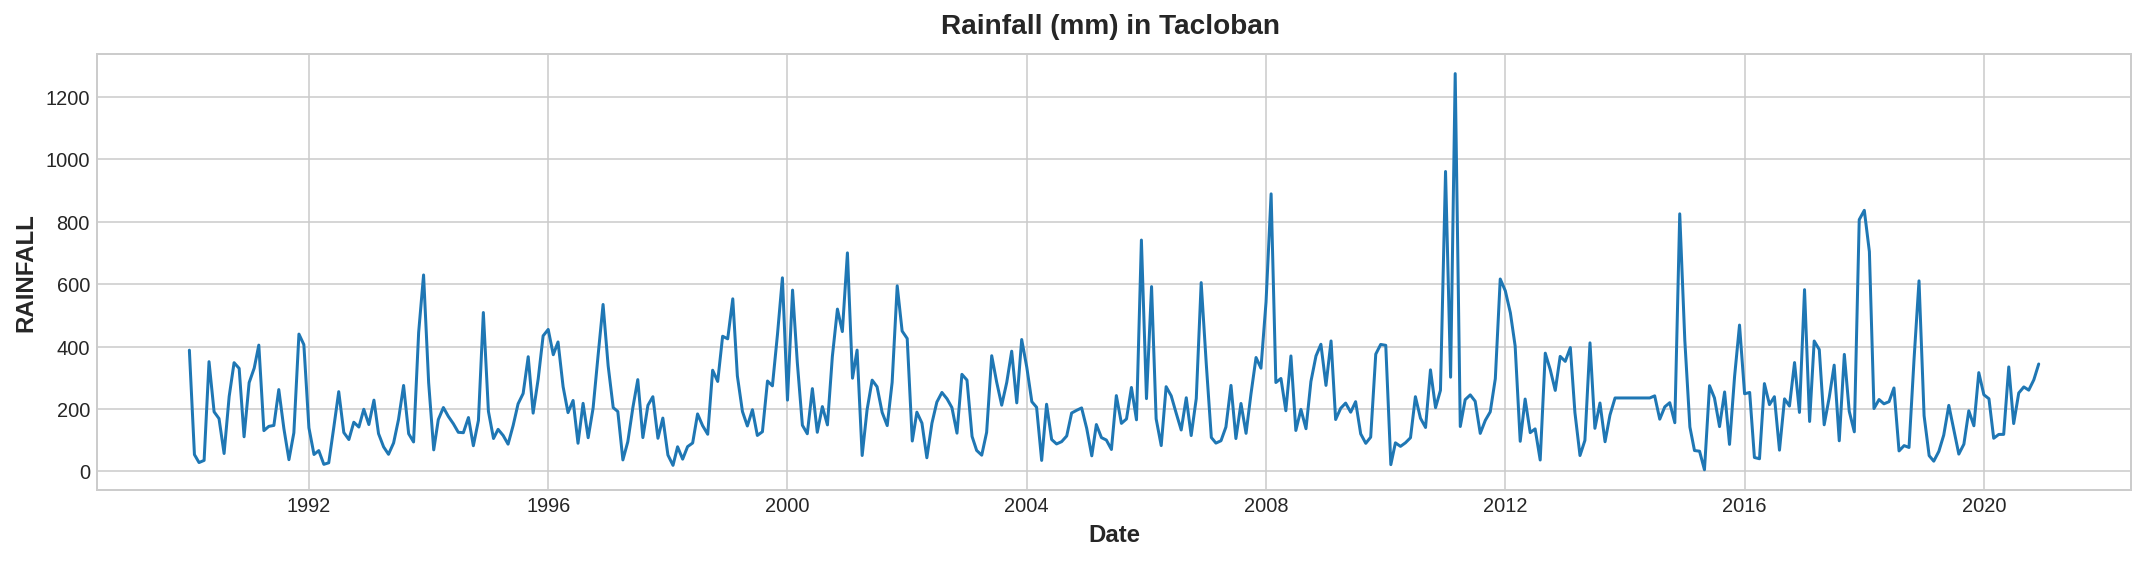

In [ ]:
plt.xlabel('Date')
plt.ylabel('RAINFALL')
plt.title("Rainfall (mm) in Tacloban ")
plt.plot(df)

#### Adding time step feature

In [ ]:
df['Time'] = np.arange(len(df.index))
df.head()

,RAINFALL,Time
Date,,
1990-01-01,388.3,0
1990-02-01,53.6,1
1990-03-01,28.2,2
1990-04-01,35.1,3
1990-05-01,351.4,4


The time dummy then lets us fit curves to time series in a time plot, where Time forms the x-axis.

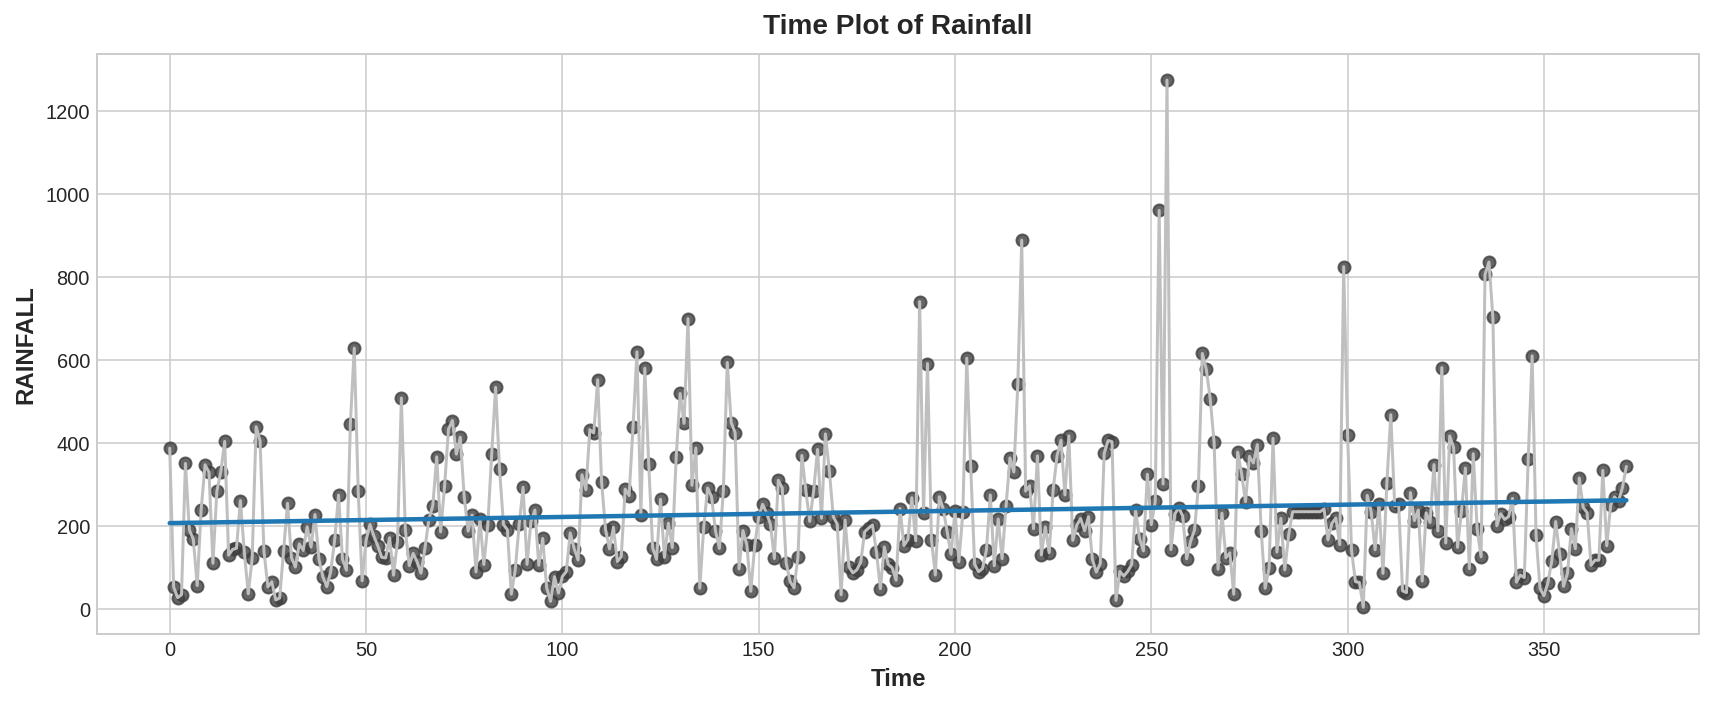

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 5)
ax.plot('Time', 'RAINFALL', data=df, color='0.75')
ax = sns.regplot(x='Time', y='RAINFALL', data=df, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title('Time Plot of Rainfall');

#### Plotting the regression model of rainfall over time

In [ ]:
X = df.loc[:, ['Time']]  # features
y = df.loc[:, 'RAINFALL']  # target

# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index=X.index)


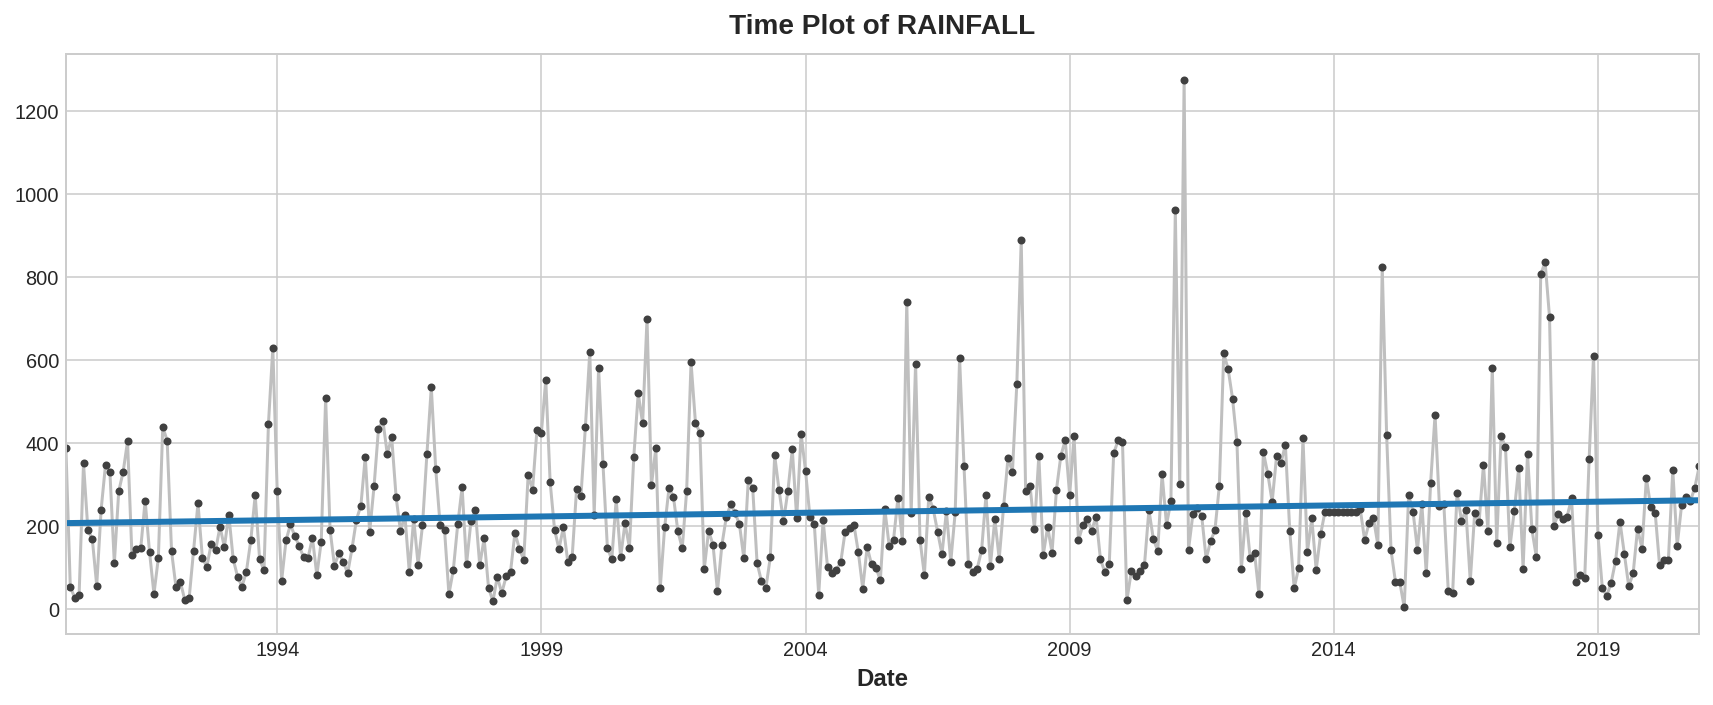

In [ ]:
ax = y.plot(**plot_params)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of RAINFALL');

#### Adding Lag Feature
   A lag feature lets you model serial dependence. A time series has serial dependence when an observation can be predicted from previous observations. Here we've created a 1-step lag feature. This will make our forecast respond to the behavior of the series in the recent past.

In [ ]:
df['Lag_1'] = df['RAINFALL'].shift(12)

In [ ]:
X = df.loc[:, ['Lag_1']]
X.dropna(inplace=True)  # drop missing values in the feature set
y = df.loc[:, 'RAINFALL']  # create the target
y, X = y.align(X, join='inner')  # drop corresponding values in target

#### Modelling the Time Series with the lag features


Text(0.5, 1.0, 'Time Series using Linear Regression')

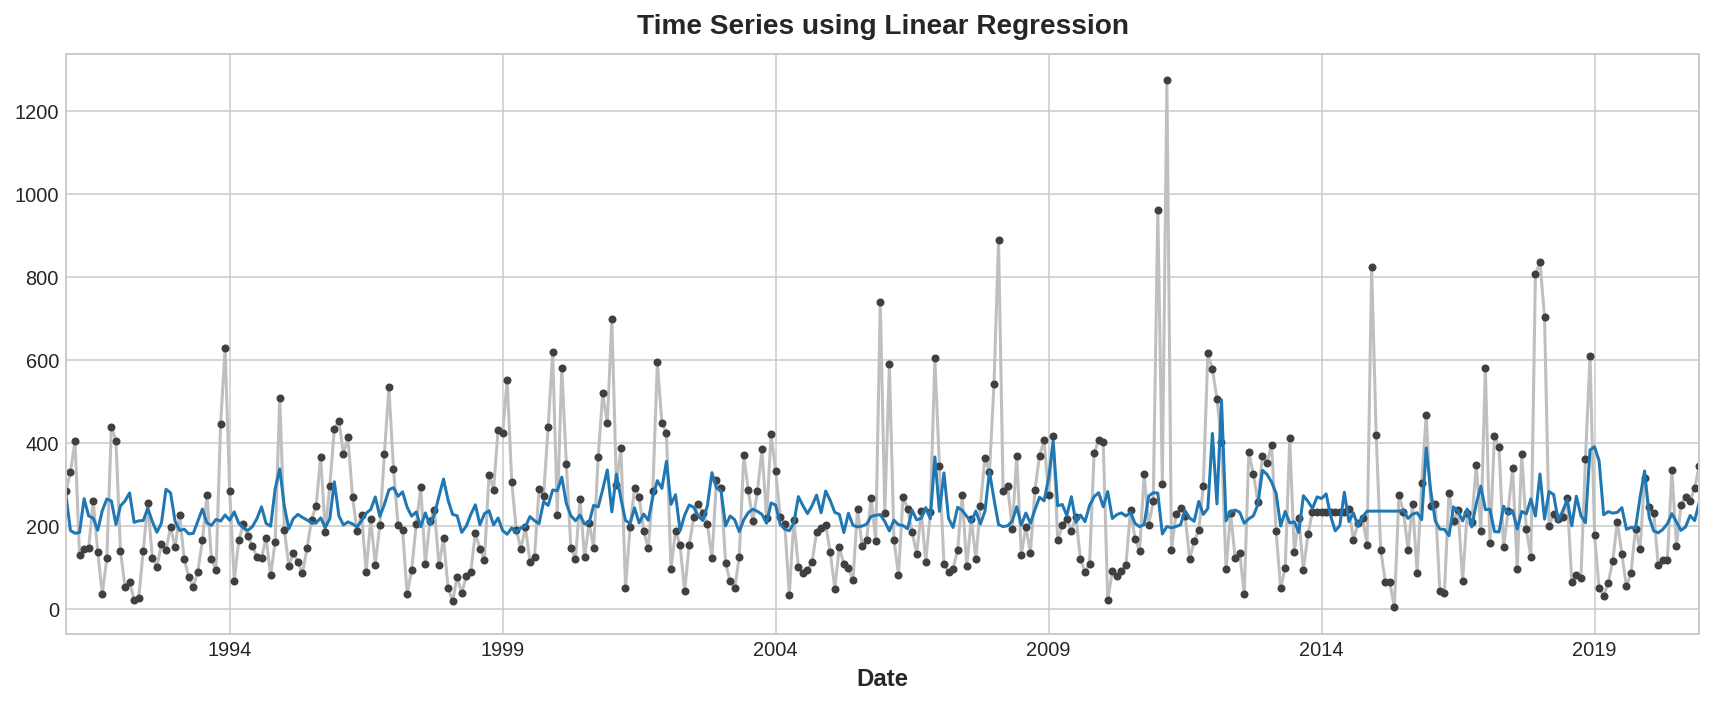

In [ ]:
model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

ax = y.plot(**plot_params)
ax = y_pred.plot()
plt.title("Time Series using Linear Regression")


#### Evaluating Regression Model with NRMSE

In [ ]:
rmse = np.sqrt(mean_squared_error(y, y_pred))
nrmse = rmse / (df['RAINFALL'].max() - df['RAINFALL'].min())
print("NRMSE:", nrmse)

NRMSE: 0.12532176290108385


## Time Series with SARIMAX
Now we try another model for our time series.
A **SARIMAX** (Seasonal Auto-Regressive Integrated Moving Average with eXogenous factors) is used if there is seasonality visible in a time series dataset. It is an updated version of the **ARIMA** model. ARIMA means Auto Regressive Integrated Moving Average. It is a combination of two models: AR (Auto Regressive) model which uses lagged values of the time series to forecast and MA (Moving Average) model that uses lagged values of residual errors to forecast. In other words, this model uses dependencies both between data values and errors values from the past to optimize the predictions.

#### Preparing the dataset

In [ ]:
df.drop(['Lag_1', 'Time'], axis = 1, inplace =True)
df.head()

,RAINFALL
Date,
1990-01-01,388.3
1990-02-01,53.6
1990-03-01,28.2
1990-04-01,35.1
1990-05-01,351.4


#### Identifying the best parameters for the SARIMAX Model using auto_arima

auto_arima() uses a stepwise approach to search multiple combinations of parameters and chooses the best model. From the results below, it is shown that the best parameters are **(2,0,0)(2,1,0)[12]**

In [ ]:
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")
  
# Fit auto_arima function to Rainfall dataset
stepwise_fit = auto_arima(df['RAINFALL'], start_p = 1, start_q = 1,
                          max_p = 3, max_q = 3, m = 12,
                          start_P = 0, seasonal = True,
                          d = None, D = 1, trace = True,
                          error_action ='ignore',   
                          suppress_warnings = True,  
                          stepwise = True)          
  
# To print the summary
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=3.15 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=4844.785, Time=0.05 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=4743.922, Time=0.94 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.34 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=4842.797, Time=0.04 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=4825.516, Time=0.10 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=4696.154, Time=2.80 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=15.26 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=3.57 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=4706.820, Time=8.53 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=4682.247, Time=5.63 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=4732.132, Time=2.21 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=8.96 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=3.95 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept   : AIC=4684.

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  372
Model:             SARIMAX(2, 0, 0)x(2, 1, 0, 12)   Log Likelihood               -2335.127
Date:                            Tue, 07 Jun 2022   AIC                           4680.255
Time:                                    11:47:45   BIC                           4699.685
Sample:                                         0   HQIC                          4687.981
                                            - 372                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1444      0.048      3.026      0.002       0.051       0.238
ar.L2          0.2124      0.041      5.210      0.000       0.133       0.292
ar.S.L12      -0.6624      0.042    -15.852      0.000      -0.744      -0.580
ar.S.L24      -0.3817      0.036    -10.536      0.000      -0.453      -0.311
sigma2      2.476e+04   1143.097     21.657      0.000    2.25e+04     2.7e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               519.21
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.19   Skew:                             1.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Fitting the data on the SARIMAX Model

In [ ]:
# Fit a SARIMAX(2, 0, 0)x(2, 1, 0, 12) on the dataset
model = SARIMAX(df, 
                order = (2, 0, 0), 
                seasonal_order =(2, 1, 0, 12))
  
result = model.fit()


#### Formulating time series prediction and comparing it to the actual data

Text(0.5, 1.0, 'Time Series using SARIMAX')

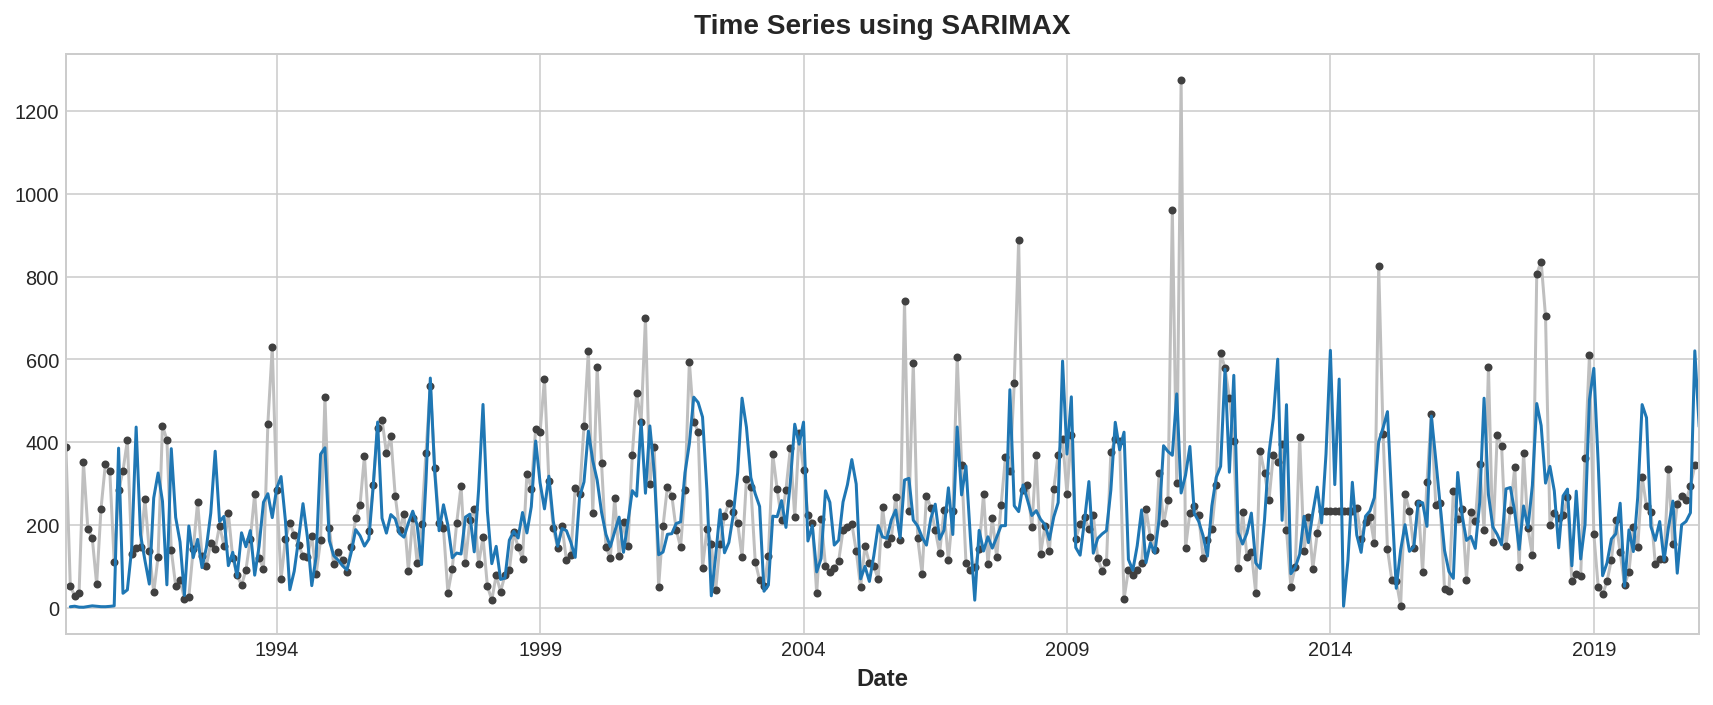

In [ ]:
ts = result.predict(1, len(df), typ = 'levels')
  
# plot predictions and actual values
ax = df.plot(**plot_params)
ax = ts.plot()
plt.title("Time Series using SARIMAX")

#### Evaluating the SARIMAX Model with NRSMSE

In [ ]:
rmse = np.sqrt(mean_squared_error(df['RAINFALL'], ts))
nrmse_sarimax = rmse / (df['RAINFALL'].max() - df['RAINFALL'].min())
print("NRMSE:", nrmse)

NRMSE: 0.12532176290108385


Observe that the NRMSE for bothe the SARIMAX and Linear Regression are the same.

#### Making a rainfall forecast from 2021-2022

Text(0.5, 1.0, 'Rain Forecast from 2021-01 to 2022-12')

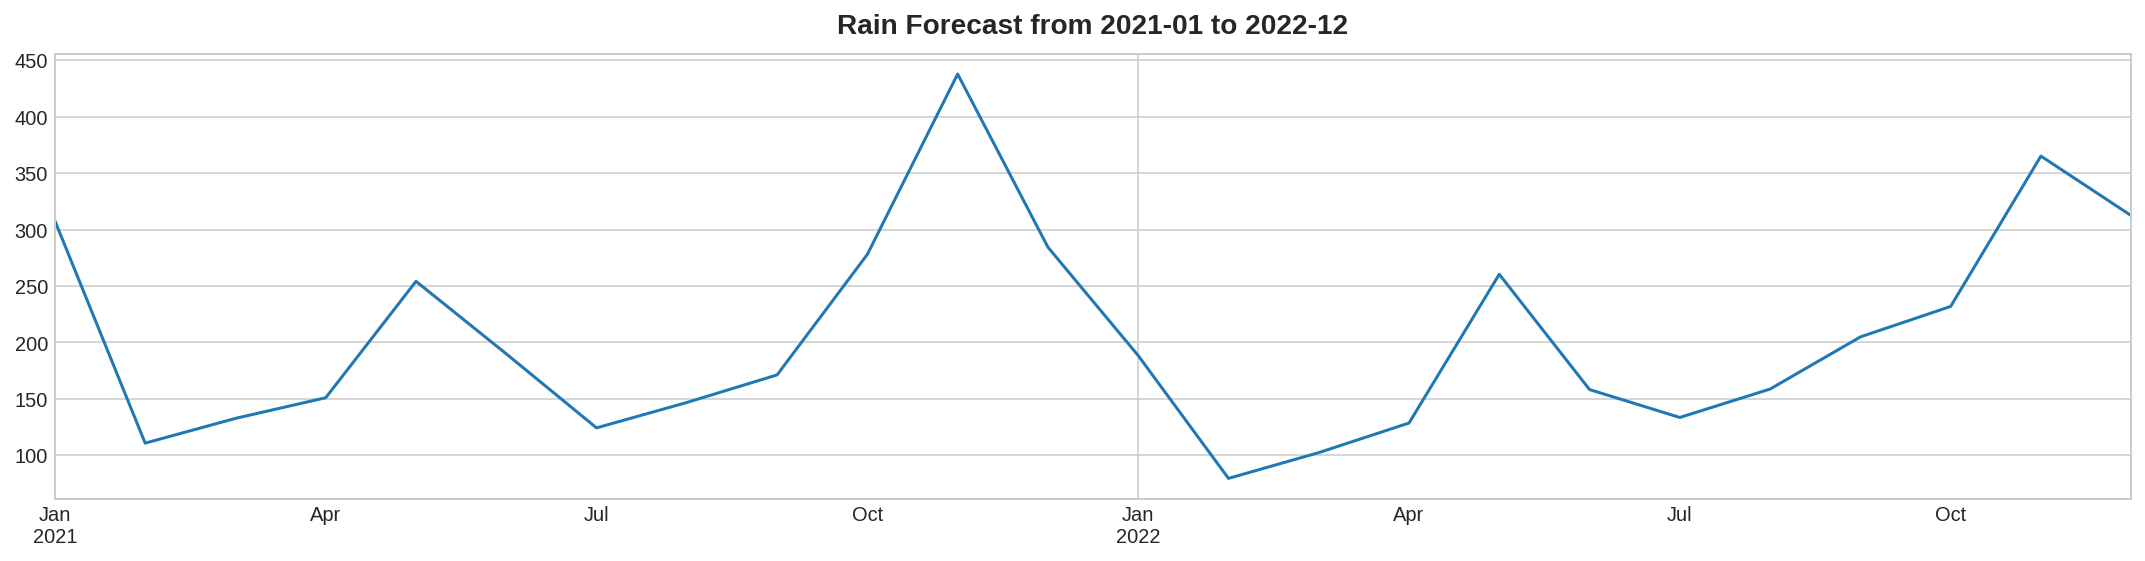

In [ ]:
start = len(df) + 1
end = len(df) + 24 #24 month prediction
index_future_dates = pd.date_range(start='2021-01-01',end='2023-01-01', freq = 'M')
fcast = result.predict(start, end,  typ = 'levels').rename("Rain Forecast")
fcast.index=index_future_dates
ax = fcast.plot()
plt.title("Rain Forecast from 2021-01 to 2022-12")

In [ ]:
fcast

2021-01-31    307.819437
2021-02-28    110.830570
2021-03-31    132.757028
2021-04-30    151.063431
2021-05-31    254.184140
2021-06-30    189.941950
2021-07-31    124.351964
2021-08-31    146.842319
2021-09-30    171.278539
2021-10-31    278.084633
2021-11-30    437.862395
2021-12-31    284.447482
2022-01-31    188.425423
2022-02-28     79.605552
2022-03-31    102.412363
2022-04-30    128.651499
2022-05-31    260.426007
2022-06-30    158.286282
2022-07-31    133.575033
2022-08-31    158.751346
2022-09-30    204.949120
2022-10-31    231.943025
2022-11-30    365.146472
2022-12-31    312.402132
Freq: M, Name: Rain Forecast, dtype: float64